In [1]:
# kaggle default imports
import numpy as np
import pandas as pd

import os


In [9]:
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/sample_submission.csv
data/test.csv
data/train.csv


Import libraries we would be making use of

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time
from wordcloud import WordCloud, STOPWORDS
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re
# Natural Language Tool Kit
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
import cufflinks as cf
cf.go_offline()

load the data, do some basic pandas eda

In [6]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
sub =  pd.read_csv("data/sample_submission.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
print(f"Train data shape {train_df.shape}")
print(f"Test data shape {test_df.shape}")

Train data shape (7613, 5)
Test data shape (3263, 4)


### Data Visualization

In the first visualization, we would be visualizing the count null values present in the train dataset.

In [5]:
missing = train_df.isnull().sum()
missing[missing>0].sort_values(ascending=False).iplot(kind='bar',
                                                      title='Null values present in train Dataset',
                                                      color=['blue'])

we can see that the location column has a lot more missing values than the keyword column. However, the text and target columns do not have any. Next we would be visualizing the fake and real disaster tweets to know if our data is balanced or imbalanced

In [8]:
train_df.target.value_counts().iplot(kind='bar',
                                     text=['Fake', 'Real'],
                                     title='Comparing Tweet is a real disaster (1) or not (0)',
                                     color=['green'])

the ratio of 1's to 0's is considerable, our dataset is balanced

In [10]:
counts_train = train_df.target.value_counts(sort=False)
labels = counts_train.index
values_train = counts_train.values

data = go.Pie(labels=labels, values=values_train, pull=[0.03, 0])
layout = go.Layout(title="Comparing Tweet is a real disaster (1) or not (0) in %")
fig = go.Figure(data=[data], layout=layout)
fig.update_traces(hole=.3, hoverinfo="label+percent+value")
fig.update_layout(
    # Add annotations in the center of the donut pies
    annotations = [dict(text='Train', x=0.5, y=0.5, font_size=20, showarrow=False)]
)
fig.show()

In [11]:
train_df['length'] = train_df['text'].apply(len)

data = [
    go.Box(
        y=train_df[train_df['target']==0]['length'],
        name='Fake'
    ),
    go.Box(
        y=train_df[train_df['target']==1]['length'],
        name='Real'
    )
]
layout = go.Layout(title='Comparison of text length in Tweets')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [12]:
print(f"There are {train_df.keyword.nunique()} in the train set") # Total number of unique keywords

train_df.keyword.value_counts()[:20].iplot(kind='bar', title='Top 20 keywords in text', color='red')

There are 221 in the train set


In [13]:
train_df.location.value_counts()[:20].iplot(kind='bar', title='Top 20 locations in tweet')

Using WordCloud to view word prominence

In [14]:
STOPWORDS.add('https')

def plot_world(text):
    comment_words = ' '
    stopwords = set(STOPWORDS)
    for val in text:
        # typecast val into string
        val = str(val)
        # split the tokens
        tokens = val.split()
        for i in range(len(tokens)):
            # converts each token into lowercase
            tokens[i] = tokens[i].lower()
        for words in tokens:
            comment_words = comment_words + words + ' '
            
    wordcloud = WordCloud(width = 5000,
                          height = 4000,
                          background_color = 'black',
                          stopwords = stopwords,
                          min_font_size = 10).generate(comment_words)
    # plot the WordCloud image
    plt.figure(figsize=(12,12), facecolor='k', edgecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

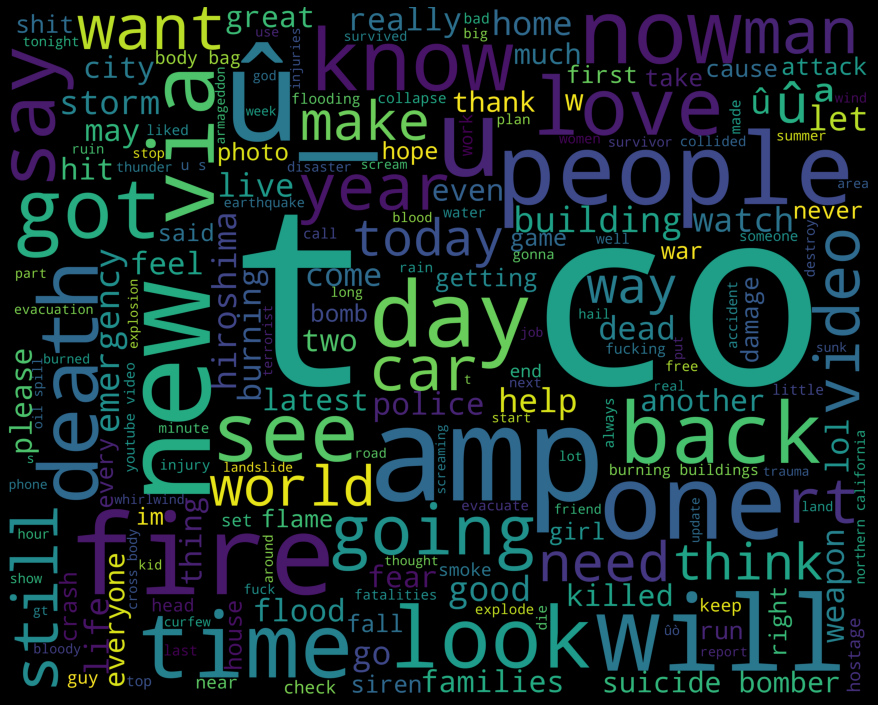

In [15]:
text = train_df.text.values
plot_world(text)

### Cleaning the Text

In [13]:
# How many http words has this text?
train_df.loc[train_df['text'].str.contains('http')].target.value_counts()

1    2172
0    1799
Name: target, dtype: int64

In [16]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_html(text):
    no_html= pattern.sub('',text)
    return no_html

# Remove all text that start with html
train_df['text'] = train_df['text'].apply(lambda x: remove_html(x))

In [17]:
# lets check if this clean works
print(train_df.loc[train_df['text'].str.contains('http')].target.value_counts())

# remove all text that start with html in test
test_df['text'] = test_df['text'].apply(lambda x: remove_html(x))

0    1
Name: target, dtype: int64


In [18]:
# now remove stopwords, change to lowercase

def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    # split to array (default delimiter is " ")
    text = text.split()
    text = [w for w in text if not w in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [19]:
# apply text cleaning
train_df['text'] = train_df['text'].apply(lambda x : clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))

In [20]:
# How many unique words have this text

def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count
text_values = train_df['text']

counter = counter_word(text_values)
print(f"The len of words is: {len(counter)}")
list(counter.items())[:10]

The len of words is: 16070


[('deeds', 2),
 ('reason', 20),
 ('earthquake', 50),
 ('may', 89),
 ('allah', 9),
 ('forgive', 2),
 ('us', 128),
 ('forest', 66),
 ('fire', 254),
 ('near', 56)]

### Train / Valid Split

In [21]:
# The maximum number of words to be used. (most frequent)

vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint
max_length = 20
trunc_type = 'post'
padding_type = 'post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6200
seq_len = 12

# based on 80% of the data
training_sentences = train_df.text[0:training_size]
training_labels = train_df.target[0:training_size]

valid_sentences = train_df.text[training_size:]
valid_labels = train_df.target[training_size:]

print('The Shape of training ',training_sentences.shape)
print('The Shape of testing',valid_sentences.shape)

The Shape of training  (6200,)
The Shape of testing (1413,)


In [22]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [23]:
# Lets see the first 10 elements
print("THe first word Index are: ")
for x in list(word_index)[0:15]:
    print (" {},  {} ".format(x,  word_index[x]))

THe first word Index are: 
 <XXX>,  1 
 amp,  2 
 like,  3 
 fire,  4 
 get,  5 
 new,  6 
 via,  7 
 people,  8 
 news,  9 
 one,  10 
 emergency,  11 
 disaster,  12 
 video,  13 
 body,  14 
 burning,  15 


In [24]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(train_df.text[1])
print(training_sequences[1])

forest fire near la ronge sask canada
[74, 4, 121, 559, 5536, 5537, 1203]


In [25]:
# check reverse to see how it works
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [26]:
# Lets see the first 10 elements
print("THe first reverse word Index are: ")
for x in list(reverse_word_index)[0:15]:
    print (" {},  {} ".format(x,  reverse_word_index[x]))

THe first reverse word Index are: 
 1,  <XXX> 
 2,  amp 
 3,  like 
 4,  fire 
 5,  get 
 6,  new 
 7,  via 
 8,  people 
 9,  news 
 10,  one 
 11,  emergency 
 12,  disaster 
 13,  video 
 14,  body 
 15,  burning 


In [27]:
def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
decode(training_sequences[1]) # this can be useful in checking predictions

'forest fire near la ronge sask canada'

In [26]:
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Creating the model

In [27]:
# Model Definition with LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # remember this is a binary classification
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            514240    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 568,065
Trainable params: 568,065
Non-trainable params: 0
_________________________________________________________________


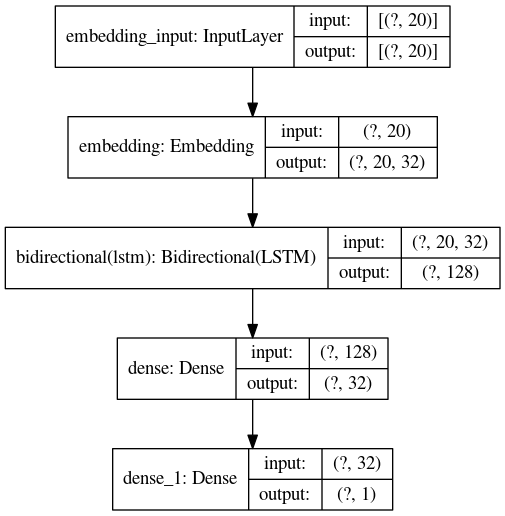

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [29]:
start_time = time.time()

num_epochs = 40
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(valid_padded, valid_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutes: {final_time}')

Train on 6200 samples, validate on 1413 samples
Epoch 1/40
6200/6200 [==============================] - 8s 1ms/sample - loss: 0.5659 - accuracy: 0.7053 - val_loss: 0.4651 - val_accuracy: 0.7969
Epoch 2/40
6200/6200 [==============================] - 4s 632us/sample - loss: 0.2987 - accuracy: 0.8823 - val_loss: 0.4918 - val_accuracy: 0.7997
Epoch 3/40
6200/6200 [==============================] - 4s 627us/sample - loss: 0.1694 - accuracy: 0.9410 - val_loss: 0.6053 - val_accuracy: 0.7495
Epoch 4/40
6200/6200 [==============================] - 4s 637us/sample - loss: 0.1159 - accuracy: 0.9623 - val_loss: 0.6663 - val_accuracy: 0.7445
Epoch 5/40
6200/6200 [==============================] - 4s 625us/sample - loss: 0.0922 - accuracy: 0.9703 - val_loss: 0.7554 - val_accuracy: 0.7445
Epoch 6/40
6200/6200 [==============================] - 4s 629us/sample - loss: 0.0790 - accuracy: 0.9735 - val_loss: 0.7432 - val_accuracy: 0.7481
Epoch 7/40
6200/6200 [==============================] - 4s 630us/s

In [30]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.565931,0.705323,0.465128,0.796886
1,0.298656,0.882258,0.491791,0.799717
2,0.169354,0.940968,0.605349,0.749469
3,0.115923,0.962258,0.666336,0.744515
4,0.092171,0.970323,0.755421,0.744515


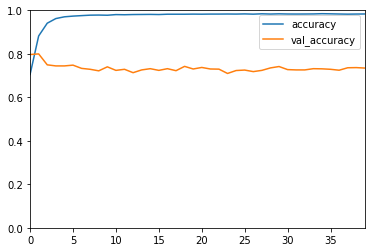

In [31]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1])

### Model Evaluation

In [32]:
predictions = model.predict_classes(valid_padded)
predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

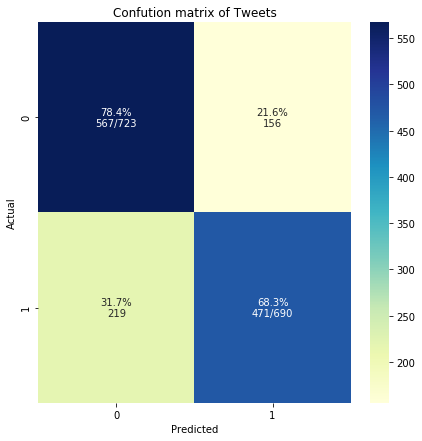

In [33]:
from sklearn.metrics import classification_report,confusion_matrix

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
# Showing Confusion Matrix
plot_cm(valid_labels,predictions, 'Confution matrix of Tweets', figsize=(7,7))

In [34]:
testing_sequences2 = tokenizer.texts_to_sequences(test_df.text)
testing_padded2 = pad_sequences(testing_sequences2, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = model.predict(testing_padded2)
# sample of submission

sub['target'] = (predictions > 0.5).astype(int)
sub.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1


In [35]:
sub.to_csv("submission.csv", index=False, header=True)